# JFET Biasing Calculator

$$
R_S = \frac{V_p}{I_D} \left(\sqrt{\frac{I_D}{I_{DSS}}} - 1\right)
$$

$$
V_{GS} = V_p \frac{I_{DSS} - \sqrt{I_D I_{DSS}}}{I_{DSS}}
$$

$$
gm = \frac{-2 I_{DSS}}{V_p} \left(1 + \frac{I_D  R_S}{V_p}\right)
$$

In [1]:
import math
import sys

# sys.path.append("../../lib")
import ipywidgets as widgets

# import numpy as np
import pint

# import plotly.graph_objects as go
import plotly.io as pio
import schemdraw as schem
import schemdraw.elements as e

# from biasing import interactive_draw_bjt_bias
from eseries import E12, E24, E48, E96, erange, find_nearest
from IPython.display import HTML, display
from ipywidgets import Layout, interactive

%matplotlib inline
%config InlineBackend.figure_format = 'svg'


# Support rendering plots in github
pio.renderers.default = "jupyterlab+png"
schem.use("svg")

ureg = pint.UnitRegistry()
layout = Layout(width="auto")
style = {"description_width": "100px"}

#################################################


def draw_jfet_bias(Idss_mA=8, Vp=-2.77, ID_mA=4, RD=0, Vd=0, VDD=9):
    Idss = Idss_mA * 10**-3
    ID = ID_mA * 10**-3

    Rs = (Vp / ID) * (math.sqrt(ID / Idss) - 1)
    Rs_nearest = find_nearest(res_series, Rs)

    Vgs = Vp * (Idss - math.sqrt(ID * Idss)) / Idss

    gm = (-2 * Idss) / Vp * (1 + (ID * Rs) / Vp)

    Vd_color = "blue"
    if Vd is None or Vd == 0:
        Vd = VDD - ID * RD
        if Vd < 0:
            Vd = 0
        Vd_color = "red"

    RD_color = "blue"
    if RD is None or RD == 0:
        RD = (VDD - Vd) / ID
        RD_color = "red"
    RD_nearest = find_nearest(res_series, RD)

    operating_region = "saturation"
    operating_region_bgcolor = "lightgreen"
    if Vd <= abs(Vp):
        operating_region = "ohmic"
        operating_region_bgcolor = "orange"

    beta = Idss / (Vp**2)

    d = schem.Drawing()

    d += e.Ground()

    d += e.Line().up().length(3.25)
    d += e.Line().right().length(1.5)

    d += (J1 := e.JFetP2(arrow=False).label("$J_1$")).anchor("gate").up().reverse()
    d += (
        e.Resistor()
        .label(
            f"$R_S$\n{(Rs*ureg.ohms):.1f~#P}\n(nearest:{(Rs_nearest*ureg.ohms):.1f~#P})",
            color="red",
            loc="bot",
        )
        .length(2)
        .down()
        .at(J1.source)
    )
    d += e.Ground()

    d += e.Dot().at(J1.source)
    d += (
        e.MeterV()
        .label(
            "$V_{GS}$\n" + f"{(Vgs*ureg.volts):.1f~#P}",
            color="red",
            loc="bot",
            fontsize=12,
        )
        .left()
        .length(2.4)
    )
    d += e.Dot()

    d += e.Dot().at(J1.drain)
    d.push()
    d += e.Line().length(1.5).right()
    d.push()

    d += e.Dot()
    d += e.Line().length(0.75).down()
    d += (
        e.MeterV()
        .length(1.5)
        .label(
            "$V_{DS}$\n" + f"{((Vd+Vgs)*ureg.volts):.2f~#P}",
            color=f"{Vd_color}",
            loc="bot",
        )
        .down()
    )
    d += e.Line().length(0.75).down()
    d += e.Line().length(1.5).left()

    d.pop()
    d += e.Line().length(2).right()
    d += (
        e.MeterV()
        .length(5)
        .label(
            "$V_D/V_{DG}$ \n" + f"{(Vd*ureg.volts):.2f~#P} ",
            color=f"{Vd_color}",
            loc="bot",
        )
        .down()
    )
    d += e.Ground()
    d.pop()
    d += (
        e.Resistor()
        .label(
            f"$R_D$\n{(RD*ureg.ohms):.1f~#P}\n(nearest:{(RD_nearest*ureg.ohms):.1f~#P})",
            color=f"{RD_color}",
        )
        .length(2)
        .up()
    )

    d += (
        e.MeterA()
        .label(f"$I_D$\n{(ID*ureg.amperes):.3f~#P}", color="blue")
        .length(2)
        .up()
        # .at(J1.drain)
    )
    d += e.Vdd().label("$V_{DD}$" + f"\n{(VDD*ureg.volts):.1f~#P}", color="blue")

    display(
        HTML(
            "<TABLE style='border-colapse:collapse; border:1px solid black;'>"
            + "<TR>"
            + "<TH style='text-align:left;' colspan='4'>Specs:-<TH style='text-align:left;' colspan='10'>Design:-"
            + "</TR><TR>"
            + (
                '<TD style="color:blue;">$I_{DSS}=$<TD style="color:blue;">'
                + f"${(Idss*ureg.amperes):.3f~#}$"
            )
            + (
                '<TD style="color:blue;">$V_P \\mid V_{GS(off)}=$<TD style="color:blue;">'
                + f"${(Vp*ureg.volts):.3f~#P}$"
            )
            + (
                '<TD style="color:blue;">$V_{DD}=$<TD style="color:blue;">'
                + f"${(VDD*ureg.volts):.1f~#P}$"
            )
            + f'<TD style="color:{RD_color};">$R_D=$<TD style="color:{RD_color};">${(RD*ureg.ohms):.1f~#}$'
            + f'<TD style="color:{Vd_color};">$V_D=$<TD style="color:{Vd_color};">${(Vd*ureg.volts):.2f~#}$'
            + (
                '<TD style="color:blue;">$I_D=$<TD style="color:blue;">'
                + f"${(ID*ureg.amperes):.3f~#}$"
            )
            + f'<TD style="color:red;">$R_S=$<TD style="color:red;">${(Rs*ureg.ohms):.1f~#}$'
            + f'<TD style="color:red;">$gm=$<TD style="color:red;">${(gm*ureg.siemens):.4f~#P}$'
            + f'<TD style="color:red;">$beta=$<TD style="color:red;">${(beta*ureg.siemens):.4f~#P}$'
            + f'<TD style="color:red;">operating region =<TD style="background-color:{operating_region_bgcolor};">{operating_region}'
            + "</TR>"
            + "</TABLE>"
        )
    )
    display(d)


res_series = E24
interactive_draw_jfet_bias = interactive(
    draw_jfet_bias,
    VDD=widgets.FloatText(
        value=9.0,
        description="$V_{DD}$",
        style=style,
    ),
    Idss_mA=widgets.FloatText(
        value=8.0,
        description="$I_{DSS}\\ mA$",
        style=style,
    ),
    Vp=widgets.FloatText(
        value=-2.77,
        description="$V_P$",
        style=style,
    ),
    RD=widgets.SelectionSlider(
        value=100.0,
        description="$R_D$",
        options=list(erange(res_series, 1.0, 20000.0)),
        style=style,
        layout=layout,
    ),
    Vd=widgets.FloatSlider(
        value=0,
        description="$V_d$",
        # options=list(erange(res_series, 1.0, 20000.0)),
        min=0,
        max=20,
        style=style,
        layout=layout,
    ),
    ID_mA=widgets.FloatSlider(
        value=4.0,
        description="$I_D\\ mA$",
        # options=list(erange(res_series, 1.0, 20000.0)),
        style=style,
        layout=layout,
    ),
)
display(interactive_draw_jfet_bias)

interactive(children=(FloatText(value=8.0, description='$I_{DSS}\\ mA$', style=DescriptionStyle(description_wi…

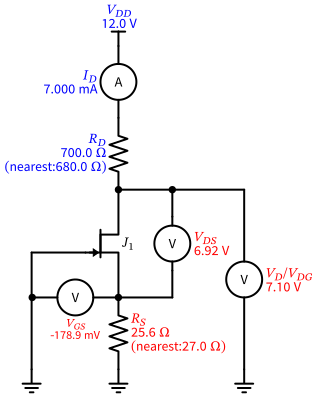

In [2]:
# Onsemi MPF102
draw_jfet_bias(Idss_mA=8, Vp=-2.77, ID_mA=7, RD=700, VDD=12)

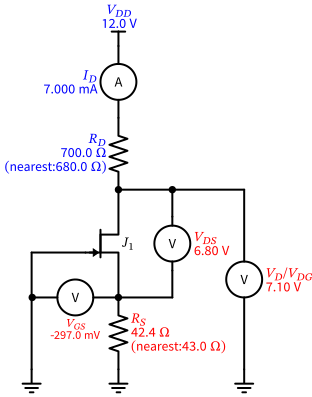

In [3]:
# Vishay Siliconix J304
# NOTE: Different pin-out: S,D,G
draw_jfet_bias(Idss_mA=8.79, Vp=-2.76, ID_mA=7, RD=700, VDD=12)

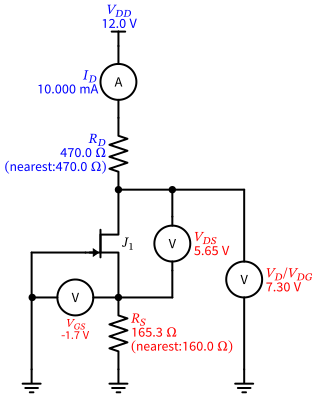

In [4]:
# Fairchild J310
draw_jfet_bias(Idss_mA=30, Vp=-3.91, ID_mA=10, RD=470, VDD=12)

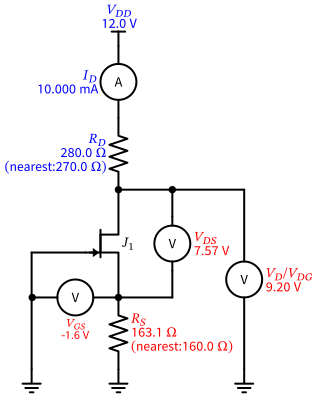

In [5]:
# Fairchild J310
draw_jfet_bias(Idss_mA=30, Vp=-3.86, ID_mA=10, RD=280, VDD=12)

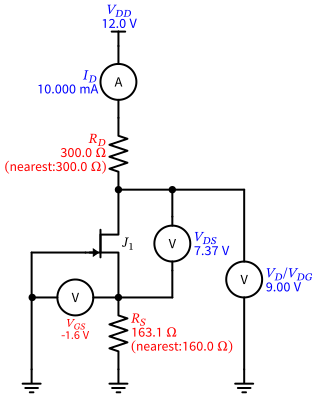

In [6]:
# Fairchild J310
draw_jfet_bias(Idss_mA=30, Vp=-3.86, ID_mA=10, Vd=9, VDD=12)